Simulated mains frequency noise data
-----------------------------------------------------------------------------------
These data have:
	Frequency     =  50.0 (Hz)
	Phase         =  0
	Normalisation =  0.5  (V)
	Constant      =  0.0  (V)
	Noise         =  50.0  (%)
	t             = [ 0 ,  0.1 ] (s)
	N(data)       =  100
-----------------------------------------------------------------------------------


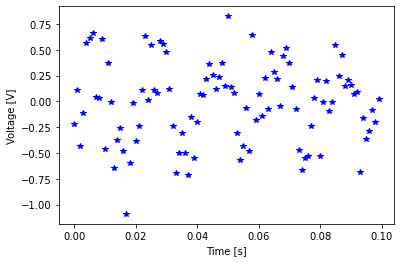

In [1]:
"""
We will use scipy for fitting, numpy for mathematical functions (including 
random number generation) and matplotlib for plotting
"""
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')  # free up memory for any pre-existing plots (when re-running the notebook)



def fitFunction(time, Normalisation, Freq, Constant, Phase):
    """
This is the model to fit for the mains frequency noise. The arguments of the function are
  time    - the x value to be fitted
  Normalisation - normalisation (amplitude of signal)
  Freq          - frequency
  Constant      - constant offset from a baseline of 0
  Phase         - phase shift

The fitted function is

  f = norm * Sin[ 2*pi*t*freq + phi ] + const

The frequency is in Hz (cycles per second), and so a value of freq=50 corresponds to 
50Hz (nominal mains frequency in the UK)

phi is a phase shift for the sinusoid

norm is the amplitude of the sinusoid

const is the voltage offset (which is not necessarily zero) for a measurement

"""
    arg = time * 2.0*np.pi*Freq + Phase     # compute the phase shifted argument for the sinusoidal oscillation
    return Normalisation * np.sin( arg )  + Constant  # compute the noise component



def print_param(name, val, err):
    """
    Helper function for printing out the formatted fit results in a readable format.
    The value and error are printed with a 5.3e precision and the print formatting is
    using Python 3 nomenclature.
    """
    significance = -999
    if( err != 0.0):
        significance = val / err
    print("{:s}  = {:5.3e} +/- {:5.3e} (stat.) [non-zero value significance = {:5.1f} sigma]".format(name,val,err, significance))
    return



"""
Simulate some data to fit; for this example we want to simulate some data with noise
over some time period in seconds. These data will be fitted in order to extract 
a 50Hz frequency noise measurement with an assumed absence of any other signal.

The parameters Normalisation, Freq, Constant, Phase correspond to the
parameters norm, freq, const, phi in the fit function defined above (see fitFunction).

N is the number of timesteps to generate in the range t = [time_min, time_max] (s)
Noise is the fraction of noise to add to the mains frequency signal.  A value of
Noise = 0.05 corresponds to a 5% Gaussian noise added to the model.
"""
time    = []
voltage = []
Freq          = 50.0
Phase         = 0
Normalisation = 0.5
Constant      = 0.0
Noise         = 0.5   # Gaussian noise to overlay
N             = 100   # the number of points used for this problem
time_min = 0
time_max = 0.1
time_step = (time_max-time_min)/N
for i in range(N):
    thisTime = i*time_step
    time.append(thisTime)
    thisV = fitFunction(time[i-1], Normalisation, Freq, Constant, Phase)
    thisV += Noise*Normalisation*np.random.normal()
    voltage.append(thisV)

"""
Plot the simulated data
"""
print("Simulated mains frequency noise data")
fig = plt.figure()
plt.plot( time, voltage, 'b*' )
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")

print("-----------------------------------------------------------------------------------")
print("These data have:")
print("\tFrequency     = ", Freq, "(Hz)")
print("\tPhase         = ", Phase)
print("\tNormalisation = ", Normalisation, " (V)")
print("\tConstant      = ", Constant, " (V)")
print("\tNoise         = ", Noise*100, " (%)")
print("\tt             = [", time_min, ", ", time_max, "] (s)")
print("\tN(data)       = ", N)
print("-----------------------------------------------------------------------------------")


Fitted results for the model are below.
-----------------------------------------------------------------------------------
normalisation    = 3.701e-01 +/- 4.075e-02 (stat.) [non-zero value significance =   9.1 sigma]
frequency        = 4.915e+01 +/- 6.214e-01 (stat.) [non-zero value significance =  79.1 sigma]
constant offset  = 1.990e-22 +/- 2.902e-02 (stat.) [non-zero value significance =   0.0 sigma]
phase            = 2.521e-18 +/- 2.192e-01 (stat.) [non-zero value significance =   0.0 sigma]
-----------------------------------------------------------------------------------

Covariance Matrix:
[[ 1.66018532e-03  8.19578631e-04 -9.54819909e-06 -3.07196523e-04]
 [ 8.19578631e-04  3.86117585e-01  1.18517360e-03 -1.17371690e-01]
 [-9.54819909e-06  1.18517360e-03  8.42400902e-04 -2.87803566e-04]
 [-3.07196523e-04 -1.17371690e-01 -2.87803566e-04  4.80624395e-02]]
-----------------------------------------------------------------------------------


Text(0, 0.5, 'Voltage [V]')

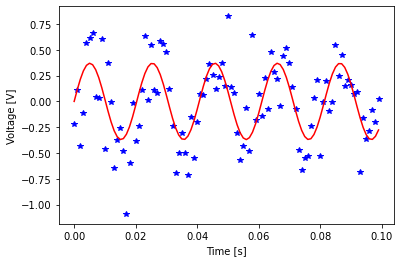

In [10]:

"""
Use the scipy optimise function to fit the data for a noise term.  This is a 
non-linear least squares to fit a function, fitFunction, to data.  Note that the
documentation for this method can be found online at

  https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit
  
"""
params, params_covariance = optimize.curve_fit(fitFunction, time, voltage, \
                                               p0 = [Normalisation, Freq, Constant, Phase] , \
                                               bounds=(0, [10, 100.0, 10, 2.0*np.pi]))

"""
The ordering of the fitted parameters corresponds to the ordering of the arguments in 
the function fitFunction.  The first argument in that function is the time.  The remaining
arguments are the local parameters:
  Normalisation - normalisation 
  Freq          - frequency
  Constant      - constant
  Phase         - phase shift
"""
fitted_norm = params[0]
fitted_norm_err = np.sqrt( params_covariance[0][0] )
fitted_freq = params[1]
fitted_freq_err =  np.sqrt( params_covariance[1][1] )
fitted_const = params[2]
fitted_const_err =   np.sqrt(params_covariance[2][2] )
fitted_phi = params[3]
fitted_phi_err =   np.sqrt(params_covariance[3][3] )

print("Fitted results for the model are below.")
print("-----------------------------------------------------------------------------------")
print_param("normalisation  ",  fitted_norm,    fitted_norm_err)
print_param("frequency      ",  fitted_freq,    fitted_freq_err)
print_param("constant offset",  fitted_const,   fitted_const_err)
print_param("phase          ",  fitted_phi,     fitted_phi_err)
print("-----------------------------------------------------------------------------------")

print("\nCovariance Matrix:")
print(params_covariance)
print("-----------------------------------------------------------------------------------")


model = []
for t in time:
    model.append( fitFunction(t, *params) )

## plot the scope trace
fig = plt.figure()
plt.plot( time, voltage, 'b*' )
plt.plot( time, model, 'r' )
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")

